- ensembles of decision trees == Random Forest and Gradient Boosting Machines
- build a Random Forests from scratch and submit to the Titanic competition.

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data preprocessing

In [2]:
# get the path for the titanic dataset in my kaggle 
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    print(f'iskaggle value: {iskaggle}')
    print(f'In the if-block')
    path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

iskaggle value: Interactive
In the if-block


In [3]:
# read the training and test dataset
print(path)
df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
# mode is the value appears the most often
# get the first row
modes = df.mode().iloc[0] 
print(f'df.mode().shape : {df.mode().shape}')
print(f'modes: {modes}')
print(f'modes.shape: {modes.shape}')


../input/titanic
df.mode().shape : (891, 12)
modes: PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object
modes.shape: (12,)


- In Random Forests, no need for dummy variables for non-numeric columns.
- Just convert those fields to Pandas categorical variables.
- The categorical variables internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number. 
- The number is an index for looking up the value in the list of all unique values.


In [4]:
df.Embarked

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

When to use log1p:

The log1p() functions calculate the natural logarithm of the sum of one plus the argument x , or loge(1 + x ). The function is designed to yield a more accurate result than the expression log( x + 1) , especially when the value of the argument is close to zero. [ref](https://www.oreilly.com/library/view/c-in-a/0596006977/re157.html#:~:text=The%20log1p()%20functions%20calculate,argument%20is%20close%20to%20zero.)

In [5]:
def proc_data(df):
    # replace the NULL value with 0
    df['Fare'] = df.Fare.fillna(0)
    # fill the NULL values with the value of modes for the corresponding columns
    df.fillna(modes, inplace=True)
    # This mathematical function helps user 
    # to calculate natural logarithmic value of x+1
    # where x belongs to all the input array elements.
    df['LogFare'] = np.log1p(df['Fare'])
    # Given a list, categorize the elements in a list of categories.
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

In [6]:
proc_data(df)
proc_data(tst_df)

In [7]:
df['Pclass']

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64

In [8]:
cats=["Sex", "Embarked"]
# conts for continuous
conts=['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep="Survived"

In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [10]:
# look at the category value for a correponding Sex value
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

**Main Point So Far: pd.Categorical() to categorize non-numeric values.**

### Binary splits

Decision Tree is built on binary split. Will find out how to build binary splits, then decision trees.

##### Binary Split

- all rows are placed into one of two groups,
- based on whether they are above or below some threshold of some column.


[Text(0.5, 1.0, 'Histogram')]

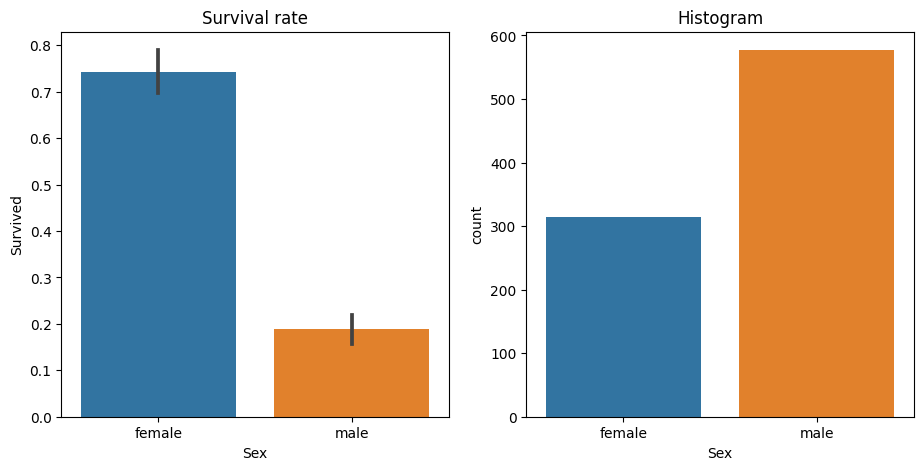

In [11]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram")

In [12]:
# A simple model: "all females survive, and no males do"
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [13]:
trn_df.head

<bound method NDFrame.head of      PassengerId  Survived  Pclass                              Name  Sex  \
298          299         1       1             Saalfeld, Mr. Adolphe    1   
884          885         0       3            Sutehall, Mr. Henry Jr    1   
247          248         1       2   Hamalainen, Mrs. William (Anna)    0   
478          479         0       3         Karlsson, Mr. Nils August    1   
305          306         1       1    Allison, Master. Hudson Trevor    1   
..           ...       ...     ...                               ...  ...   
106          107         1       3  Salkjelsvik, Miss. Anna Kristine    0   
270          271         0       1             Cairns, Mr. Alexander    1   
860          861         0       3           Hansen, Mr. Claus Peter    1   
435          436         1       1         Carter, Miss. Lucile Polk    0   
102          103         0       1         White, Mr. Richard Frasar    1   

       Age  SibSp  Parch           Ticket    

In [14]:
df[dep].head

<bound method NDFrame.head of 0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64>

In [15]:
# create independent variables (i.e. the x variables) and dependent variables (i.e. y variables)
def xs_y(df):
    xs = df[cats+conts].copy()
    # dep = "Survived". y value is df[dep] which is the "Survied" column
    return xs,df[dep] if dep in df else None

In [16]:
df[dep]

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [17]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [18]:
val_xs.head

<bound method NDFrame.head of      Sex  Embarked   Age  SibSp  Parch   LogFare  Pclass
709    1         0  24.0      1      1  2.787834       3
439    1         2  31.0      0      0  2.442347       2
840    1         2  20.0      0      0  2.188856       3
720    0         2   6.0      0      1  3.526361       2
39     0         0  14.0      1      0  2.504848       3
..   ...       ...   ...    ...    ...       ...     ...
880    0         2  25.0      0      1  3.295837       2
425    1         2  24.0      0      0  2.110213       3
101    1         2  24.0      0      0  2.185579       3
199    0         2  24.0      0      0  2.639057       2
424    1         2  18.0      1      1  3.054591       3

[223 rows x 7 columns]>

In [19]:
val_xs.Sex.head

<bound method NDFrame.head of 709    1
439    1
840    1
720    0
39     0
      ..
880    0
425    1
101    1
199    0
424    1
Name: Sex, Length: 223, dtype: int8>

In [20]:
val_xs.Sex==0

709    False
439    False
840    False
720     True
39      True
       ...  
880     True
425    False
101    False
199     True
424    False
Name: Sex, Length: 223, dtype: bool

In [21]:
# prediction for the simple model: "all females survive, and no males do"
# female is coded as 0
preds = val_xs.Sex==0  # ?? This assigns preds to True or False values, how is it a prediction?
# val_xs.Sex selects the column of Sex. val_xs.Sex==0 returns a column of the evaluation result which is True or False.

In [22]:
val_y.head, preds.head

(<bound method NDFrame.head of 709    1
 439    0
 840    0
 720    1
 39     1
       ..
 880    1
 425    0
 101    0
 199    0
 424    0
 Name: Survived, Length: 223, dtype: int64>,
 <bound method NDFrame.head of 709    False
 439    False
 840    False
 720     True
 39      True
        ...  
 880     True
 425    False
 101    False
 199     True
 424    False
 Name: Sex, Length: 223, dtype: bool>)

In [23]:
# use mean absolute error to measure how good this model is
from sklearn.metrics import mean_absolute_error
# In Python, True is 1 and False is zero. Therefore, val_y can compare with preds
mean_absolute_error(val_y, preds)

0.21524663677130046

In [24]:
df.LogFare>0

0      True
1      True
2      True
3      True
4      True
       ... 
886    True
887    True
888    True
889    True
890    True
Name: LogFare, Length: 891, dtype: bool

In [25]:
df.Survived

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

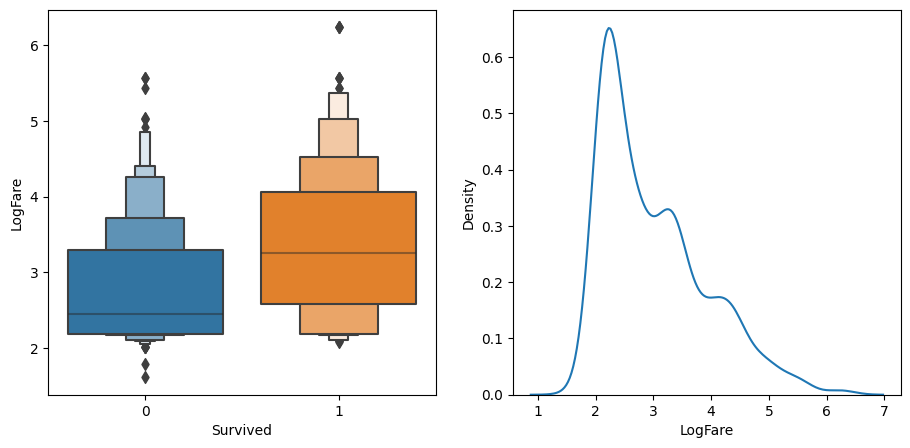

In [26]:
# Try splitting on a continuous column.
# use LogFare.  note "df['LogFare'] = np.log1p(df['Fare'])"
df_fare = trn_df[trn_df.LogFare>0]  # df['Fare'] is always > 0
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])

# A kernel density estimate (KDE) plot is a method for visualizing the distribution of 
# observations in a dataset, analogous to a histogram. KDE represents the data using a 
# continuous probability density curve in one or more dimensions.
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

# In the boxenplot, blue one is for not survived, and orange is the survived.
# the horizontal line inside the biggest box in each plot is the median line.
# It shows that the median LogFare for passengers that didn't survive is around 2.5
# and for those that did survive is around 3.2. So paid more seems to get put on a lifeboat.


In [27]:
preds = val_xs.LogFare>2.7
preds

709     True
439    False
840    False
720     True
39     False
       ...  
880     True
425    False
101    False
199    False
424     True
Name: LogFare, Length: 223, dtype: bool

In [28]:
mean_absolute_error(val_y, preds)
# This is less accurate than the model that used Sex as the single binary split.

0.336322869955157

- Want to try more columns and breakpoints more easily.
- will create a function that returns how good our model is, so can try out a few different splits.
- measure of impurity: how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.
- measure the similarity of rows inside a group by taking the standard deviation of the dependent variable.

In [29]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: 
        return 0
    return y[side].std()*tot

In [30]:
# Calculate the score for a split by adding up the scores for the "left hand side" (lhs)
# and "right hand side" (rhs).
# lhs is the condition in which the column is less or equal to the split value.
def score(col, y, split):
    lhs = col<=split
#     print(f'lhs: \n{lhs}\n')
#     print(f'~lhs: \n{~lhs}\n')
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [31]:
trn_xs["Sex"], trn_y

(298    1
 884    1
 247    0
 478    1
 305    1
       ..
 106    0
 270    1
 860    1
 435    0
 102    1
 Name: Sex, Length: 668, dtype: int8,
 298    1
 884    0
 247    1
 478    0
 305    1
       ..
 106    1
 270    0
 860    0
 435    1
 102    0
 Name: Survived, Length: 668, dtype: int64)

In [32]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [33]:
score(trn_xs["LogFare"], trn_y, 0.5)

0.48282577488540546

In [34]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [35]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

In [36]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [37]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
# The numpy. argmin() method returns indices of the min element of 
# the array in a particular axis. 
# Return : Array of indices into the array with same shape as array.
unq[scores.argmin()]

6.0

So the Age column, 6 is the optimal cutoff according to our training set.

In [38]:
def min_col(df, nm):
    col,y = df[nm], df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [39]:
# try all columns
cols = cats+conts
{o:min_col(trn_df,o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

So Sex<=0 is the best split we can use.

OneR (i.e. OneRule, actually One Feature) classifier.
baseline.

In this "preds = val_xs.Sex==0", mean_absolute_error was 0.215.

### Creating a decision tree

Our OneR classifier predicts survival based only on Sex.
How to improve this classifier?
Will split the female group and the male group. Will remove Sex from the list of possible splits as we have used it in the first split already.

In [40]:
cols.remove("Sex")

In [41]:
ismale = trn_df.Sex==1

In [42]:
males,females = trn_df[ismale], trn_df[~ismale]

In [43]:
# find the single best binary split for males
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

In [44]:
# find the single best binary split for females
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

The next binary split for males is Age<=6, and for females is Pclass<=2.

Decision Tree: first split by Sex -> female or male, the split by Age for male and Pclass for female.

In [45]:
# create the decision tree use sklearn. The DecisionTreeClassifier automatic determine the splits.
from sklearn.tree import DecisionTreeClassifier, export_graphviz
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [46]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                     special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree  {{ size={size}; ratio={ratio}', s))

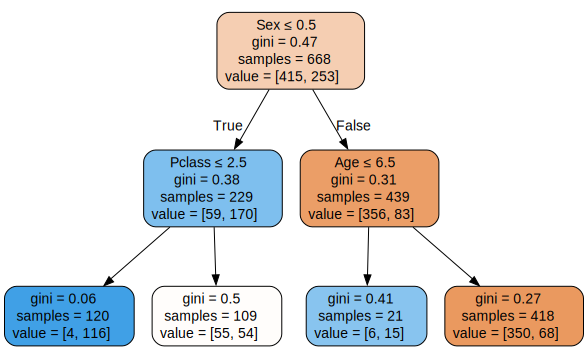

In [47]:
draw_tree(m, trn_xs, size=10)

Found exactly the same splits as we did.

More orange nodes have a lower survuval rate, and blue have higher survival.

"gini": another measure of impurity, similar to sccore()


[see a blog article on Gini](https://blog.quantinsti.com/gini-index/)

**What is Gini Index (AKA Gini impurity)?**
- measures the probability of a particular variable being wrongly classified when it is randomly chosen.

**What is meant by "impurity"?**
- By "pure" meaning if all the elements belong to a single class.
- Gini Index is in the range of 0 and 1.
- 0: all elements belong to a class (only one class)
- 1: elements are randomly distributed across various classes (impure)
- 0.5 denotes equally distributed elements into some classes.

**Similar Terms**
- Splitting measures, information gain
- when constructing a decision tree:
    - which features as root node.
    - most accurate features as internal nodes (aka leaf nodes).
- most relevant at top, level of impurity (or uncertainty) decreases down the tree.
- information gain: which feature/attribute gives the max. info about a class.
- entropy: the degree of uncertainty, impurity or disorder.
- information gain: to reduce the level of entropy starting from the root node to the leaf nodes.

**Relevance of Entropy**
- Entropy measures the impurity in a dataset. Gini is to decrease the level of entropy from the dataset.
- Entropy measures the randomness in the values of the dataset.
- entropy: between 0 and 1
- entropy of 1 --> more impurity
 




In [48]:
cond=df.Sex=='female'
dep
cond
df.loc[cond, dep]

1      1
2      1
3      1
8      1
9      1
      ..
880    1
882    0
885    0
887    1
888    0
Name: Survived, Length: 314, dtype: int64

In [49]:
df.loc[cond, dep].mean()

0.7420382165605095

In [50]:
act = df.loc[cond, dep]
act.mean() 

0.7420382165605095

In [51]:
# "gini": another measure of impurity, similar to score()
# This method calculates the probability of two rows picked from a group are the same.
# if the group is all the same, the probability is 1.0, and 0.0 if they are all different.
def gini(cond):
    # returns the elements that Sex=='female' and in the survived column
    # this line gets the survived column of Sex=='female'
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2  # see the formula below.

# mean here is the probability because mean is calculated by summing up all the values in the column.
# which are either 1s or 0s. When summing up, only 1's are counted as 0 add to anything is anything.
# so it is like proportion of female survived/total survived. So it is the probability.

In [52]:
gini(df.Sex=='female')

0.3828350034484158

### Formula for Entropy

$$ E(S) =  \sum_{i=1}^{c} -{p_i}{log_2}{p_i}  $$

where 'p' denotes the probability of entropy and E(S) denotes the entropy.

### Formula of Gini Index

$$ Gini = 1 - \sum_{i=1}^{n} ({p_i})^2 $$

where $p_i$ is the probability of an object being classified to a particular class.

While building the decision tree, choose the attribute/feature with the least Gini Index as the root node.

If the group is all the same, the probability is 1.0 (very pure), if very different, then
the probability is 0.0.

In [53]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

In [54]:
# How this model compare to the OneR version?
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

Because small dataset (around 200 rows in the validation set), so error is a bit worse.
Perhaps will see better results if we create a bigger tree.

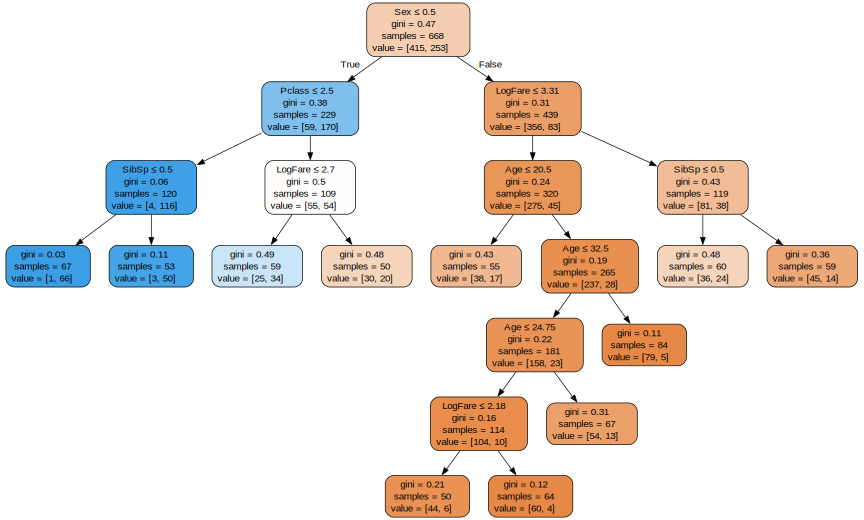

In [55]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [56]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

In [57]:
# submit to Kaggle
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId', 'Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)
    
subm(m.predict(tst_xs), 'tree')

In [58]:
# instead of dummy variables use categories
df.Embarked.head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [59]:
# resulting in integer codes with category
df.Embarked.cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

### The random forest